In [65]:
import numpy as np 
import pandas as pd 
import os
import string
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
import keras

from keras import optimizers
from keras import metrics

from keras.callbacks import TensorBoard
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model


In [66]:
# Read in metadata on images
image_MoA = pd.read_csv('/home/emily/image_MoA.csv')

# Focus on a set of images with that have already been preprocessed into numpy arrays
image_MoA_subset = image_MoA[(image_MoA.experiment == 'HUVEC-1') & image_MoA.plate.isin((1,2,3,4,5,6,7,8,9))].copy()

# Define which categories to target in this intial attempt, focus on the most represented ligand types
image_MoA_subset['category'] = image_MoA_subset.mechanism.map({'GPCR agonist': 0, 'Growth factor': 1, 'Interleukin': 2})

# Ensure metadata is sorted to align with image arrays
image_MoA_subset.sort_values(['plate', 'well'], inplace = True)

# Identify indices of images that are not included in target categories
null_rows = image_MoA_subset.category.isnull()

# Remove null values to reduce dataframe to target categories. 
image_MoA_subset = image_MoA_subset[image_MoA_subset['category'].notna()]

print(image_MoA_subset.category.value_counts())
print(image_MoA_subset.shape)

1.0    6360
2.0    5064
0.0    4203
Name: category, dtype: int64
(15627, 14)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [67]:
image_MoA_subset.head()

,Unnamed: 0,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,mechanism,Unnamed: 2,Unnamed: 3,category
288,288,HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,GDF-1,0.1,Growth factor,NaN,NaN,1.0
289,289,HUVEC-1_1_AA04_2,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,2,GDF-1,0.1,Growth factor,NaN,NaN,1.0
290,290,HUVEC-1_1_AA04_3,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,3,GDF-1,0.1,Growth factor,NaN,NaN,1.0
291,291,HUVEC-1_1_AA04_4,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,4,GDF-1,0.1,Growth factor,NaN,NaN,1.0
576,576,HUVEC-1_1_AA05_1,HUVEC-1_1_AA05,HUVEC,HUVEC-1,1,AA05,1,CCL14a,0.1,GPCR agonist,NaN,NaN,0.0


In [68]:
# List of plates with images processed into npy arrays
npy_list = ['plate_1_1.npy', 'plate_1_2.npy', 'plate_1_3.npy', 'plate_1_4.npy','plate_1_5.npy', 'plate_1_6.npy', 'plate_1_7.npy', 'plate_1_8.npy', 'plate_1_9.npy']

In [69]:
# Load in preprocessed iamges
all_npy = np.empty((0,100,100,6)).astype('float32')
for npy_ in npy_list:
    print(npy_)
    loaded_npy = np.load('/home/emily/' + npy_).astype('float32')
    #Use float 32 for memory reasons
    all_npy = np.append(all_npy, loaded_npy, axis = 0)

plate_1_1.npy
plate_1_2.npy
plate_1_3.npy
plate_1_4.npy
plate_1_5.npy
plate_1_6.npy
plate_1_7.npy
plate_1_8.npy
plate_1_9.npy


In [70]:
# Remove image arrays of non-target categories
no_null_npy = np.delete(all_npy, null_rows, axis = 0)
no_null_npy.shape

(15627, 100, 100, 6)

In [71]:
def train_val_test(image_array, y_target):
    """Input: pre-processed array of images and y-target (specified mechanism of actions)
    Output: Train-validation-test splits stratified on target classes"""        
    # Assign X and y 
    X_ = image_array
    y_ = y_target

    # Train-test split
    X_train_, X_test, y_train_, y_test = (train_test_split(X_, y_, 
                                                     test_size = .2, random_state = 22, stratify = y_))
    
    X_train, X_valid, y_train, y_valid = (train_test_split(X_train_, y_train_, 
                                                     test_size = .25, random_state = 42, stratify = y_train_))
    
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [72]:
X_train, y_train, X_test, y_test, X_valid, y_valid = train_val_test(no_null_npy, image_MoA_subset.category)


In [73]:
# Normalize image array pixel intensity values to a range of 0-1 
X_train /= 255
X_valid /= 255
X_test /= 255

In [74]:
X_train.shape

(9375, 100, 100, 6)

In [75]:
np_utils.to_categorical(y_train).shape

(9375, 3)

In [76]:
# Create dictionary to balance classes in training 
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.239587465291551, 1: 0.8189203354297694, 2: 1.0286372613561554}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0. 1. 2.], y=29492     1.0
40151     1.0
53346     2.0
100526    2.0
5522      2.0
         ... 
45325     2.0
37801     1.0
73718     2.0
88428     1.0
68581     1.0
Name: category, Length: 9375, dtype: float64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [83]:
opt_ = optimizers.Adam(lr=0.05, beta_1 = 0.9)

CNN16 = Sequential([InputLayer(input_shape=X_train.shape[1:]),
            Conv2D(16, (3,3), activation=keras.layers.LeakyReLU(alpha=0.2), padding='same', kernel_initializer = 'he_normal'),
            MaxPooling2D(),
            Conv2D(32, (3,3), activation=keras.layers.LeakyReLU(alpha=0.2), padding='same', kernel_initializer = 'he_normal'),
            MaxPooling2D(),
#                          Conv2D(64, (3,3), activation=keras.layers.LeakyReLU(alpha=0.2), padding='same'),
#                          MaxPooling2D(),
            Flatten(),
#                          Dense(128, activation = keras.layers.LeakyReLU(alpha=0.2)),
#                          Dropout(0.1), 
                         Dense(64, activation = keras.layers.LeakyReLU(alpha=0.2)),
                         Dropout(0.1), 
#                          Dense(32, activation =  keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer = 'l1'),
#                          Dropout(0.2), 
                         Dense(8, activation =  keras.layers.LeakyReLU(alpha=0.2)),
                         Dense(3, activation='softmax')]) 
CNN16.compile(
    loss='categorical_crossentropy',
    optimizer= opt_,
    metrics=[metrics.categorical_accuracy],
)

In [84]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
import datetime


early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience=10, restore_best_weights=True)
learning_rate = keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = CNN16.fit(
    X_train,
    np_utils.to_categorical(y_train),
    epochs = 500,  
    validation_data = (X_valid, np_utils.to_categorical(y_valid)), class_weight = class_weight_dict,
    batch_size = 64, callbacks = [early_stop, learning_rate, tensorboard_callback]
)



Train on 9375 samples, validate on 3126 samples
Epoch 1/500
9375/9375 [==============================] - 27s 3ms/step - loss: 1.1138 - categorical_accuracy: 0.3644 - val_loss: 1.0949 - val_categorical_accuracy: 0.4082
Epoch 2/500
9375/9375 [==============================] - 26s 3ms/step - loss: 1.0933 - categorical_accuracy: 0.3833 - val_loss: 1.0943 - val_categorical_accuracy: 0.3784
Epoch 3/500
9375/9375 [==============================] - 26s 3ms/step - loss: 1.0544 - categorical_accuracy: 0.4457 - val_loss: 1.1430 - val_categorical_accuracy: 0.3093
Epoch 4/500
9375/9375 [==============================] - 26s 3ms/step - loss: 0.9084 - categorical_accuracy: 0.5807 - val_loss: 1.2016 - val_categorical_accuracy: 0.3337
Epoch 5/500
9375/9375 [==============================] - 26s 3ms/step - loss: 0.6531 - categorical_accuracy: 0.7281 - val_loss: 1.4704 - val_categorical_accuracy: 0.3522

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/500
9375/9375

In [89]:
from matplotlib import pyplot as plt
def plot_loss(model):
    history = model.history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim(bottom = 0)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig('' + '_loss.png')


In [90]:
def plot_acc(model):
    history = model.history
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.ylim(bottom = 0)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig('local_minima' + '_accuracy.png')


In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix

def model_performance(model, y_test, X_test):
    print('Accuracy ' + str(accuracy_score(y_test, np.argmax(model.predict(X_test), axis = -1))))
    print('Confusion matrix') 
    print(confusion_matrix(y_test, np.argmax(model.predict(X_test), axis = -1)))
    print(model.summary())
    plot_loss(model)
    plot_acc(model)

Accuracy 0.3896353166986564
Confusion matrix
[[ 15 578 248]
 [ 26 886 360]
 [ 25 671 317]]
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 100, 100, 16)      880       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                1280064   
_____________________________

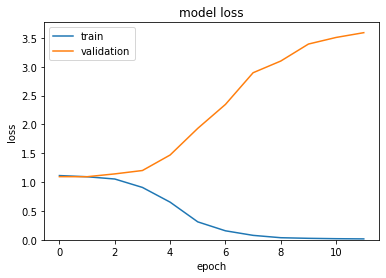

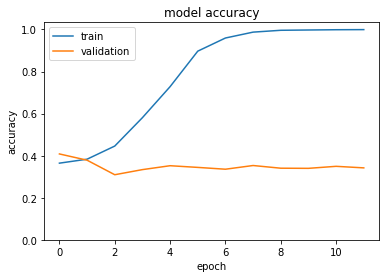

<Figure size 432x288 with 0 Axes>

In [93]:
model_performance(CNN16, y_test, X_test)

In [ ]:
model_performance(CNN1, y_test, X_test)

In [ ]:
model_performance(CNN2, y_test, X_test)

In [ ]:
# Used SGD instead of Adam for optimizer, gradient descent blew up 
model_performance(CNN3, y_test, X_test)

In [ ]:
# Reduced learning rate of SGD, caused it to go to local minima
model_performance(CNN4, y_test, X_test)

In [ ]:
# Changed SGD momentum to 0.5, once again converged to local minima
model_performance(CNN5, y_test, X_test)

In [ ]:
# Changed to adam optimizer w/ lr = 0.001, went to local minima
model_performance(CNN6, y_test, X_test)

In [ ]:
# Adam optimizer with lr = 0.01, once again, went to local minima
model_performance(CNN7, y_test, X_test)

In [ ]:
# Adam optimizer with lr = 0.01, once again, went to local minima
model_performance(CNN8, y_test, X_test)

In [ ]:
model_performance(CNN9, y_test, X_test)

In [ ]:
model_performance(CNN10, y_test, X_test)

In [ ]:
model_performance(CNN11, y_test, X_test)

In [ ]:
model_performance(CNN12, y_test, X_test)